In [126]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [127]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

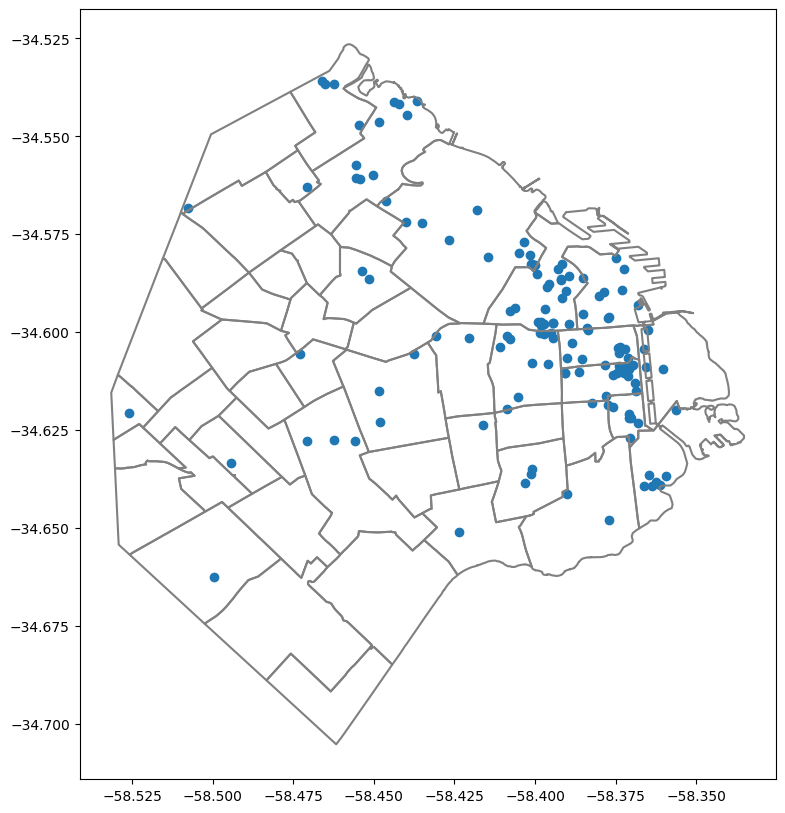

In [128]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [129]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [130]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [131]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

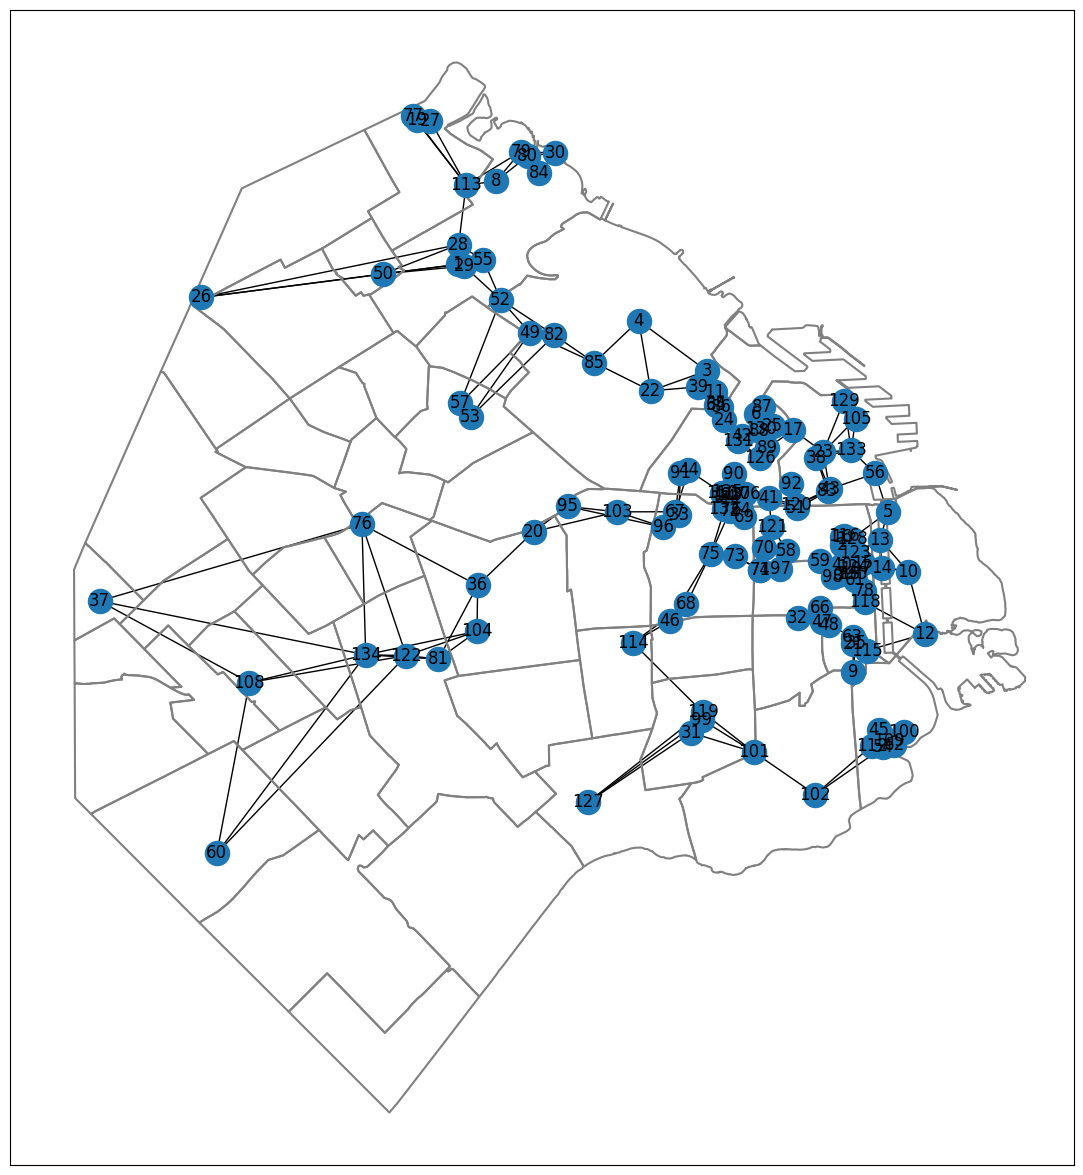

In [132]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

## Punto 2:


## Punto 3:

In [133]:
import template_funciones as func

In [134]:
def graficar(p):
  node_size = p.T[0] * 50000

  fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
  barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
  nx.draw_networkx(G,G_layout,ax=ax, node_size=node_size) # Graficamos los museos
  plt.show()

def graficar_bar_plot(df, alpha, m):
  ax = df.head(3).plot(kind='bar', x='nodes', y='score', legend=False, title=f'Top 3 puntajes con alpha={alpha} y m={m} ')
  plt.xlabel('Nodes')
  plt.ylabel('Score')
  
  # Add values on top of each bar
  for p in ax.patches:
      ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=10)
  
  plt.show()

def create_df(nodes, score, alpha, m):
  size = len(nodes)
  a_arr = [alpha]*size
  m_arr = [m]*size

  df = pd.DataFrame({"nodes":nodes,"score":score, "alpha":a_arr, "m":m_arr})
  df = df.sort_values(by="score", ascending=False)
  return df

summary_df = pd.DataFrame({"nodes":[],"score":[], "alpha":[], "m":[]})

### a)

0.024135005552429516


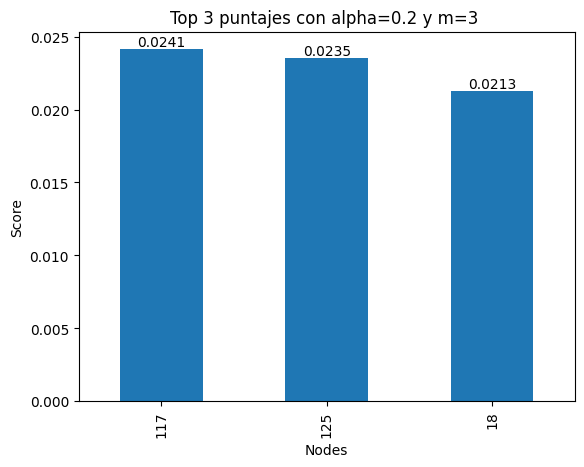

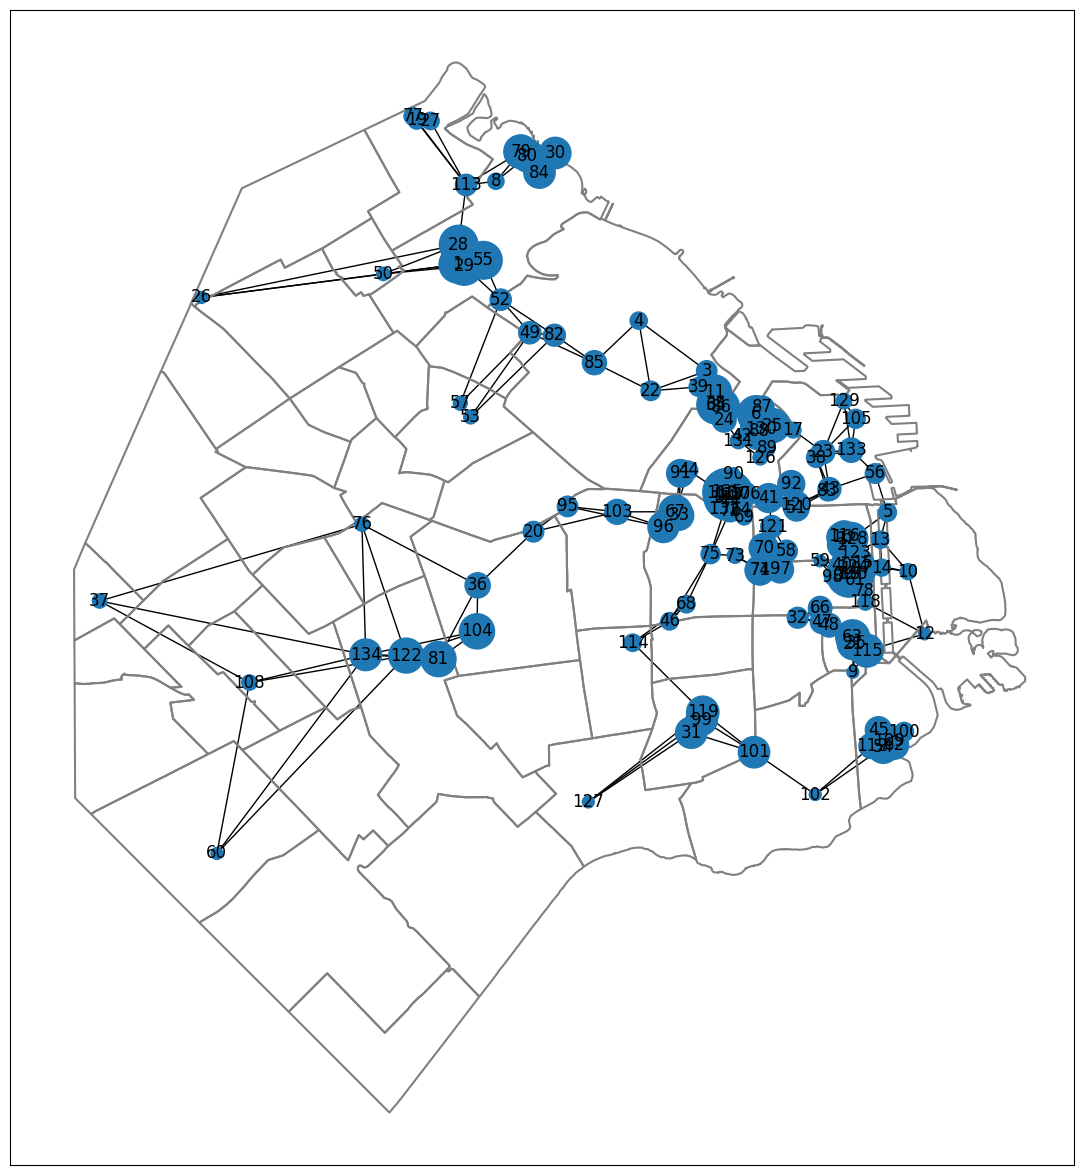

In [149]:
m = 3
alpha = 1/5
A = func.construye_adyacencia(D, m)

p = func.calcula_pagerank(A,alpha)
df = create_df(G.nodes, p.T[0], alpha, m)

first_score = float(df["score"].iloc[0])
print(first_score)

graficar_bar_plot(df, alpha, m)

summary_df = pd.concat([summary_df, df.head(3)], ignore_index=True)


graficar(p)

### b)

In [ ]:
links = [1,3,5,10]
alpha = 1/5
max_values = []
for m in links:
  A = func.construye_adyacencia(D, m)
  p = func.calcula_pagerank(A,alpha)
  print(f"m = {m}")
  df = create_df(G.nodes, p.T[0], alpha, m)
  max_values.append(df["score"].iloc[0])
  print(df.head(3))
  graficar_bar_plot(df, alpha, m)
  graficar(p)


m = 1
     nodes     score  alpha  m
65      65  0.022124    0.2  1
107    107  0.021706    0.2  1
34      34  0.021288    0.2  1
m = 3
     nodes     score  alpha  m
117    117  0.024135    0.2  3
125    125  0.023529    0.2  3
18      18  0.021281    0.2  3
m = 5
     nodes     score  alpha  m
93      93  0.021736    0.2  5
125    125  0.021614    0.2  5
117    117  0.021066    0.2  5
m = 10
     nodes     score  alpha   m
124    124  0.018665    0.2  10
135    135  0.018338    0.2  10
15      15  0.018291    0.2  10


COMENTARIO DE NAHUE:

Cuando se aumenta la cantidad de conecciones, el score más alto parece disminuír. Habría que probar esto de una mejor forma

[1, 3, 5, 10]
[np.float64(0.022124183006535954), np.float64(0.024135005552429516), np.float64(0.021736255894120298), np.float64(0.01866544381551542)]


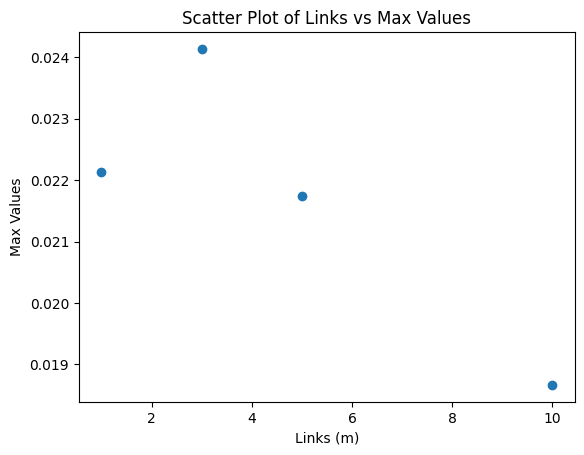

In [156]:
print(links)
print(max_values)
plt.scatter(links, max_values)
plt.xlabel('Links (m)')
plt.ylabel('Max Values')
plt.title('Scatter Plot of Links vs Max Values')
plt.show()

### c)

alpha = 0.8571428571428571
     nodes     score     alpha  m
18      18  0.008878  0.857143  3
117    117  0.008834  0.857143  3
88      88  0.008753  0.857143  3


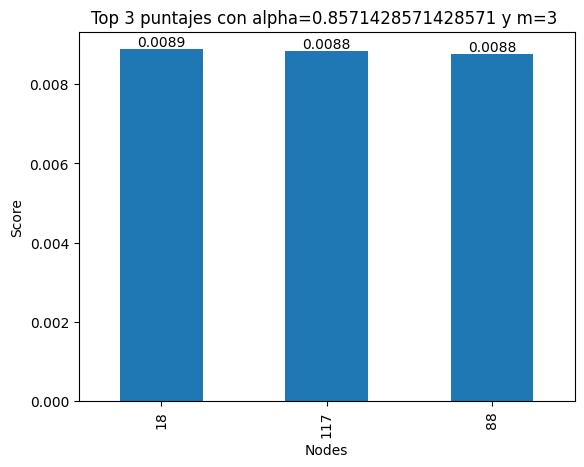

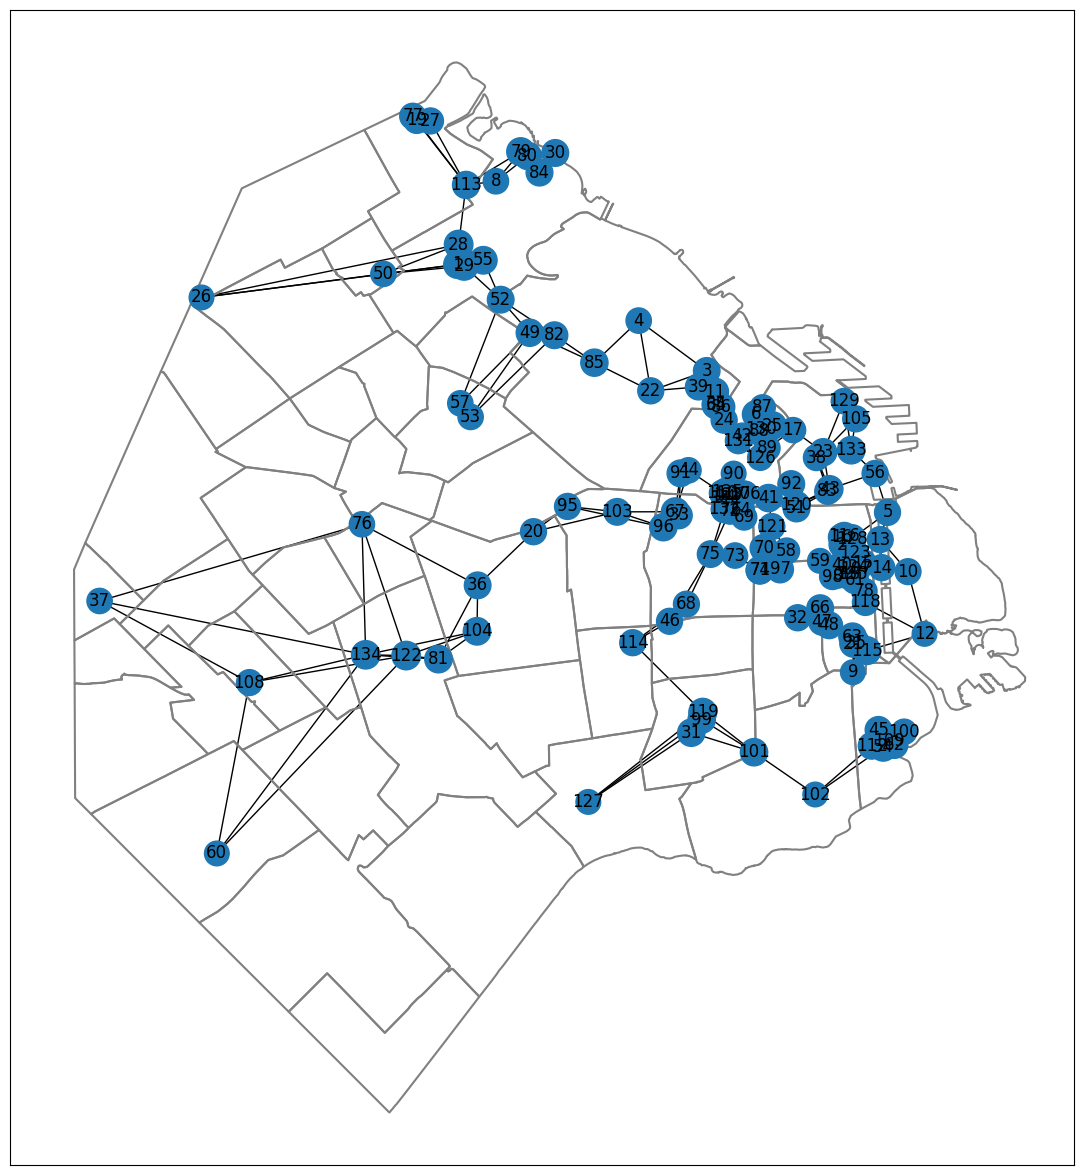

alpha = 0.8
     nodes     score  alpha  m
18      18  0.009565    0.8  3
117    117  0.009486    0.8  3
88      88  0.009312    0.8  3


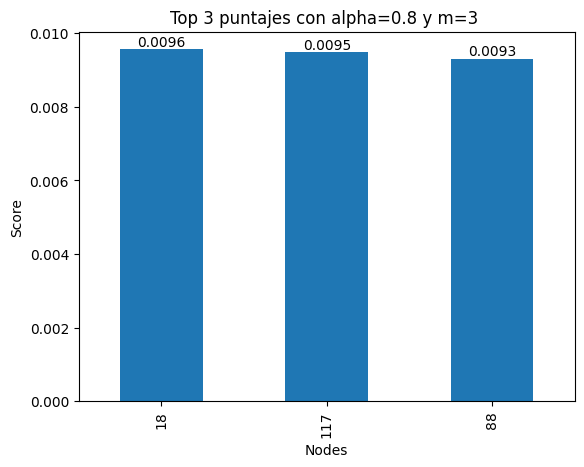

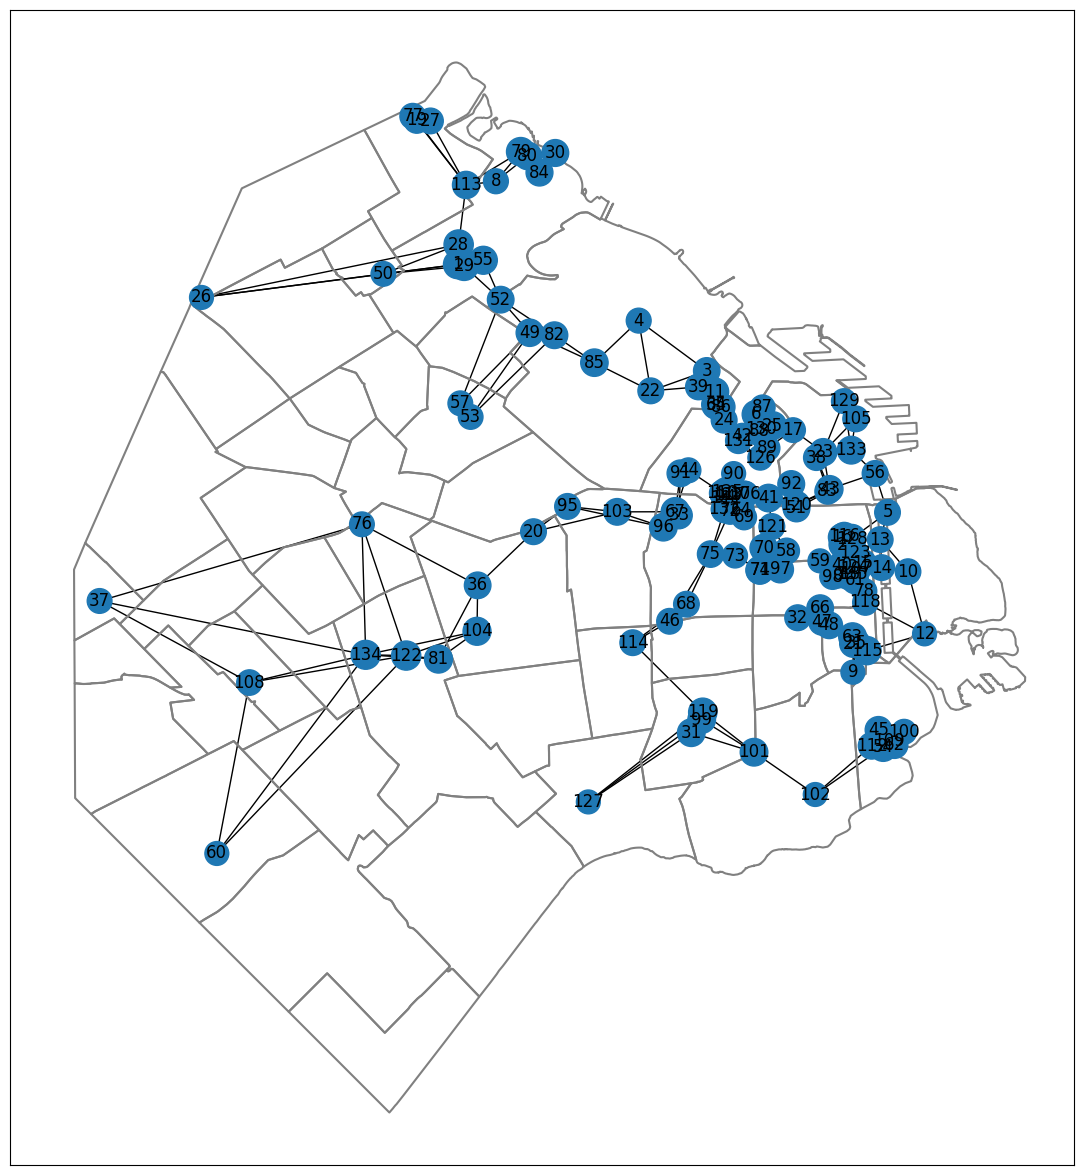

alpha = 0.6666666666666666
     nodes     score     alpha  m
18      18  0.011371  0.666667  3
117    117  0.011202  0.666667  3
124    124  0.010651  0.666667  3


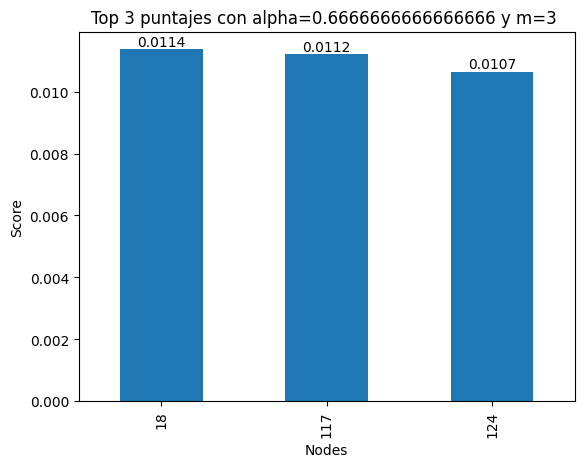

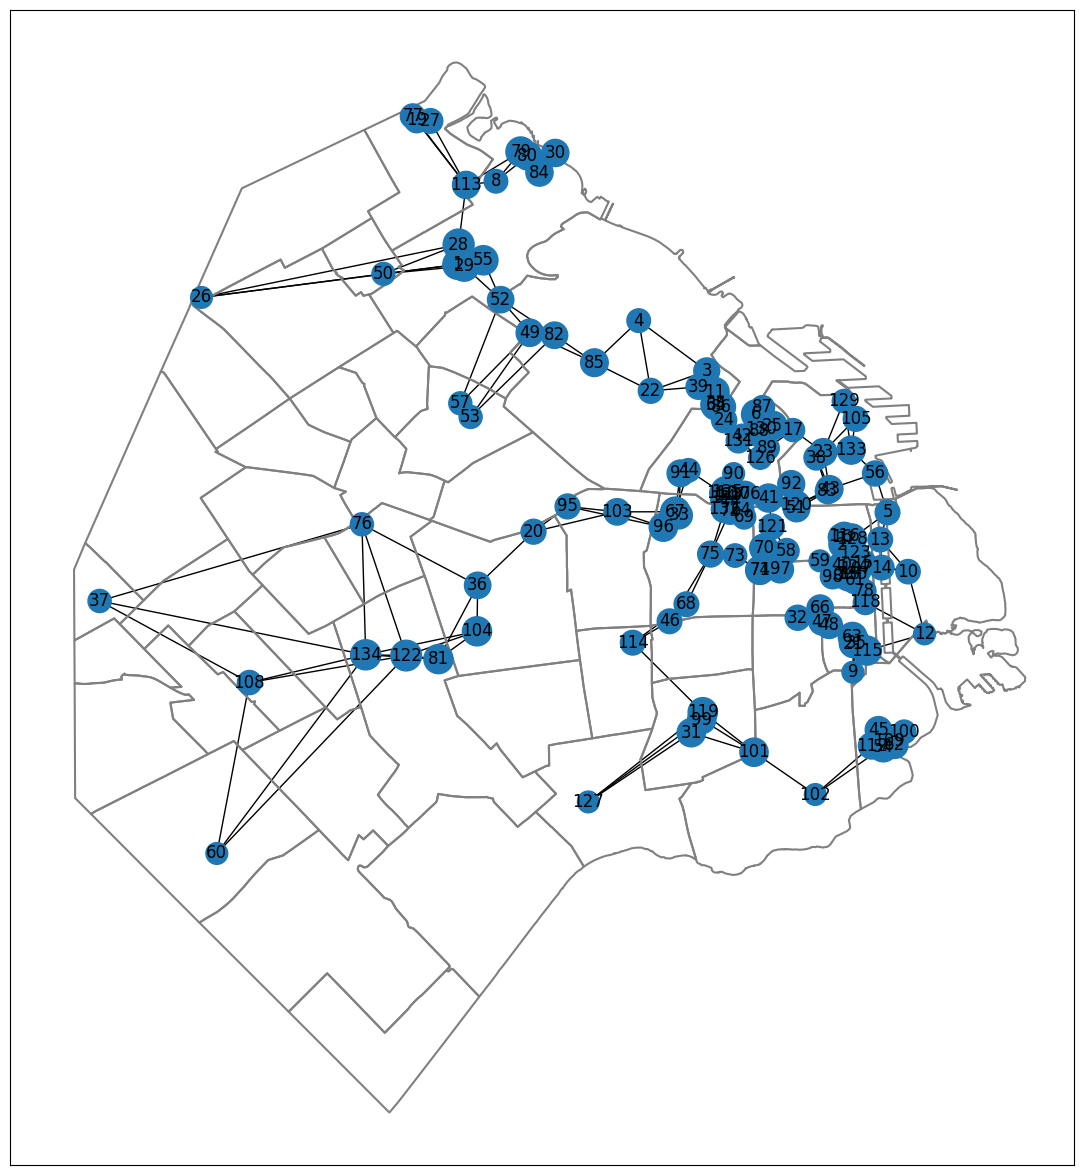

alpha = 0.5
     nodes     score  alpha  m
18      18  0.014128    0.5  3
117    117  0.013980    0.5  3
124    124  0.013112    0.5  3


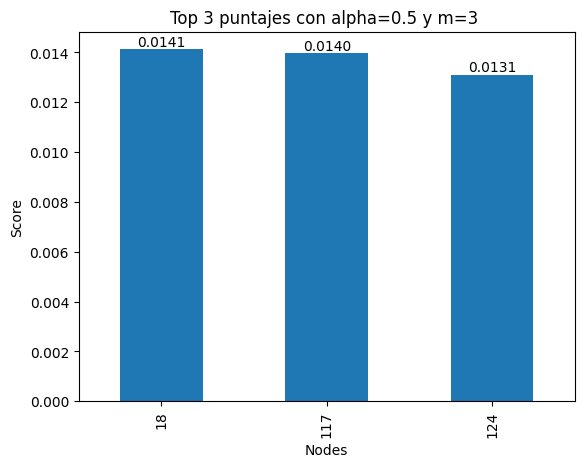

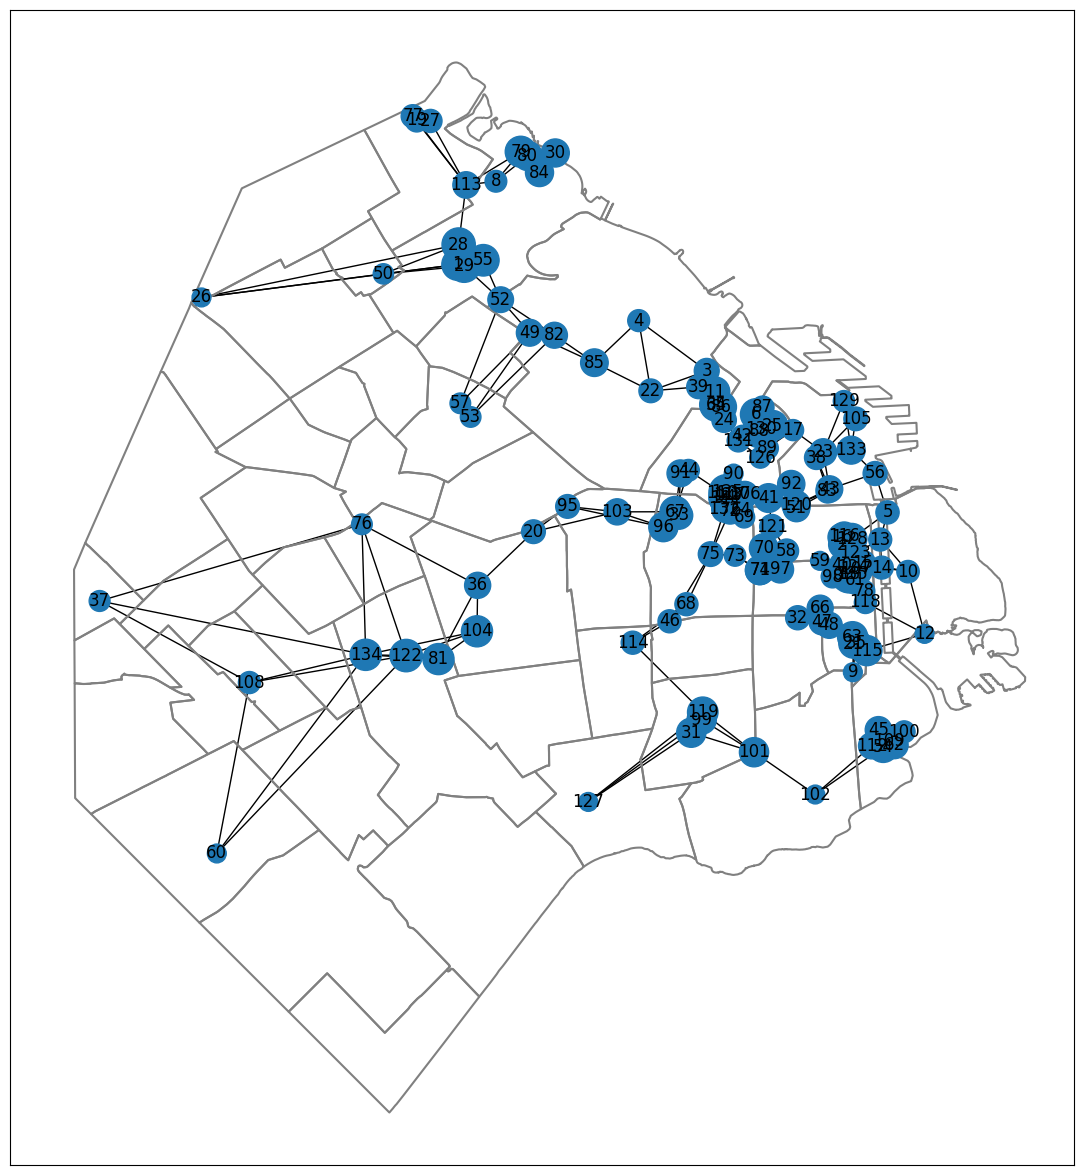

alpha = 0.3333333333333333
     nodes     score     alpha  m
117    117  0.018199  0.333333  3
18      18  0.017652  0.333333  3
125    125  0.017194  0.333333  3


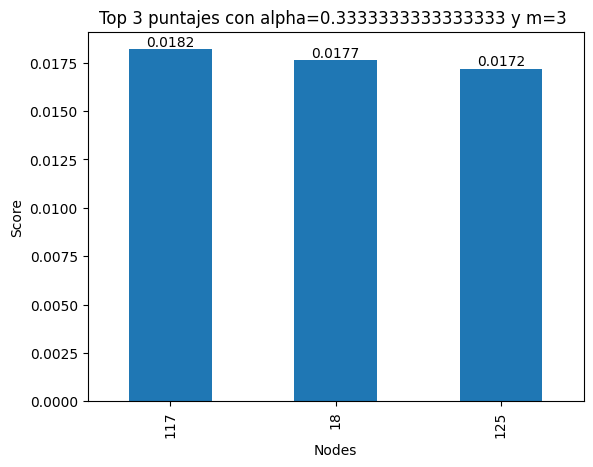

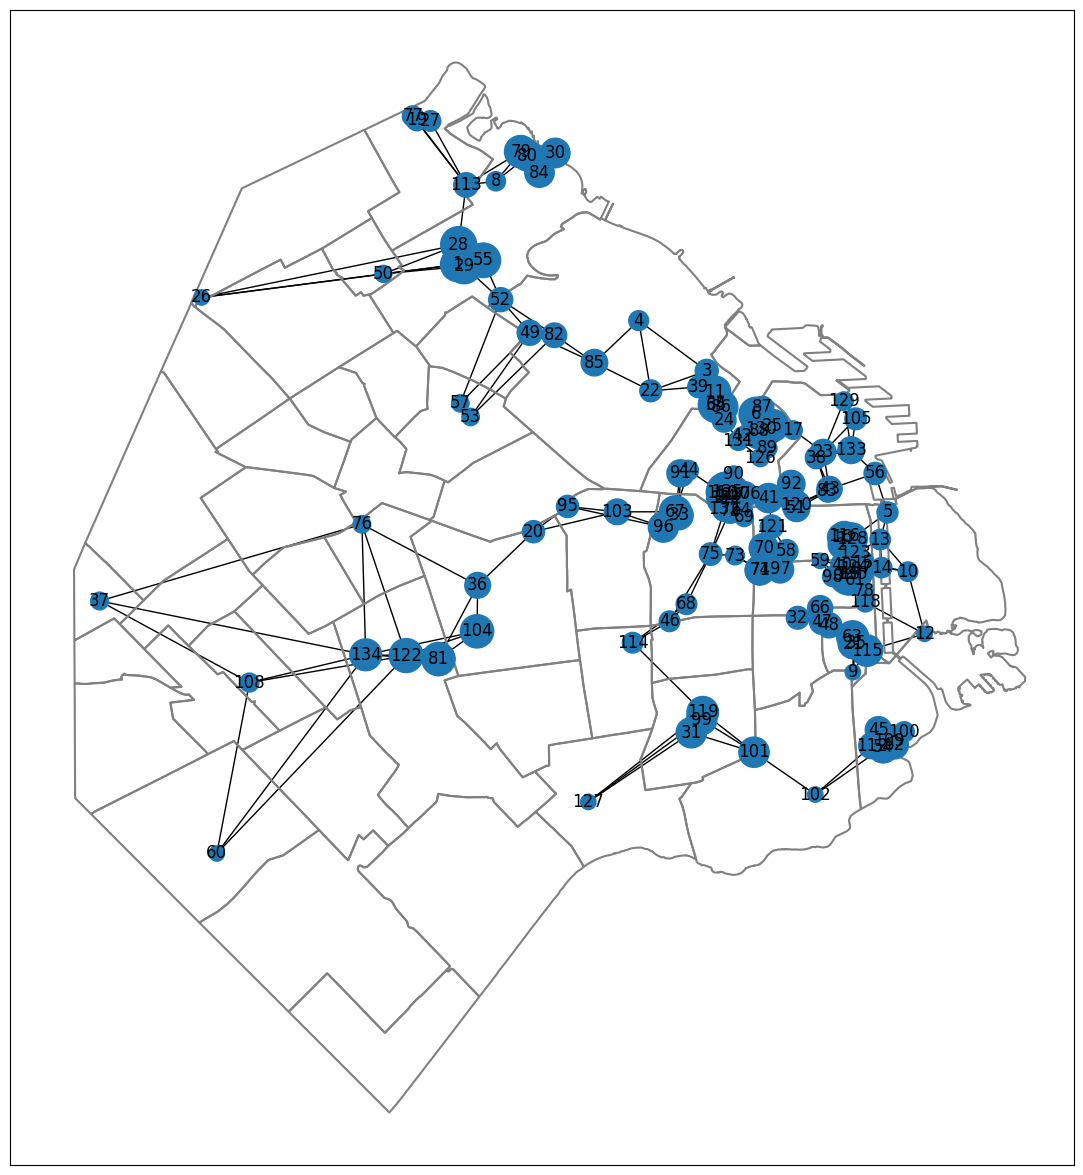

alpha = 0.2
     nodes     score  alpha  m
117    117  0.024135    0.2  3
125    125  0.023529    0.2  3
18      18  0.021281    0.2  3


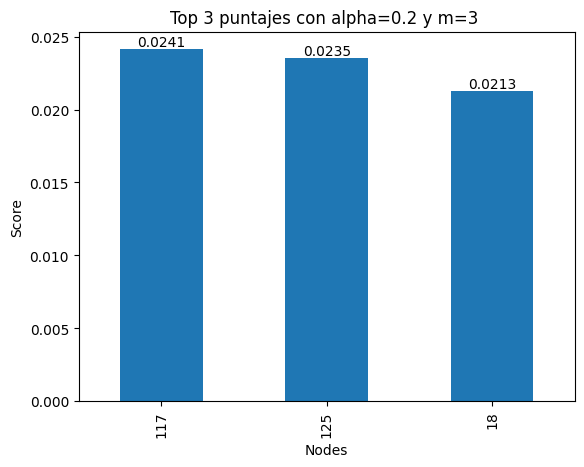

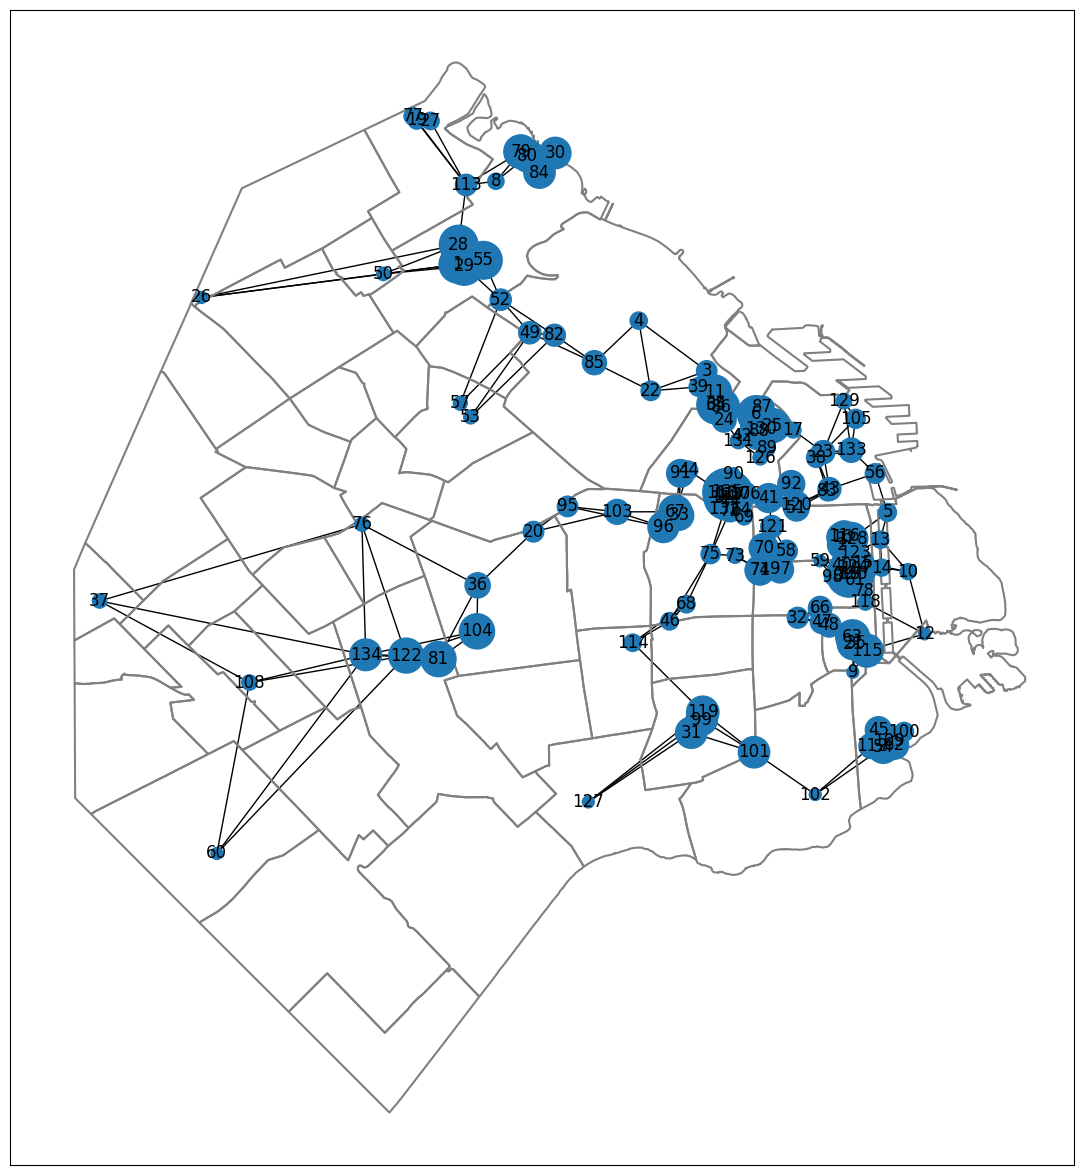

alpha = 0.14285714285714285
     nodes     score     alpha  m
117    117  0.028383  0.142857  3
125    125  0.028281  0.142857  3
111    111  0.023527  0.142857  3


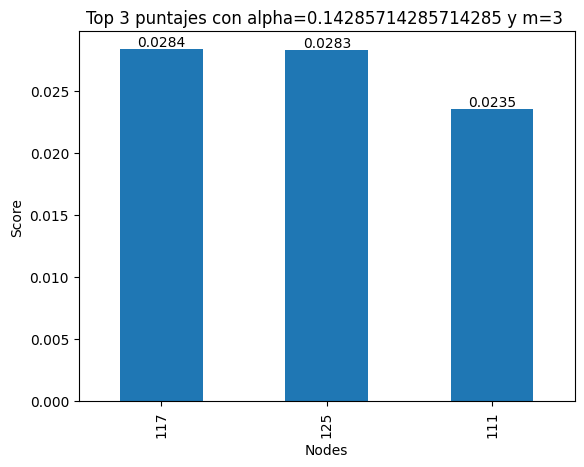

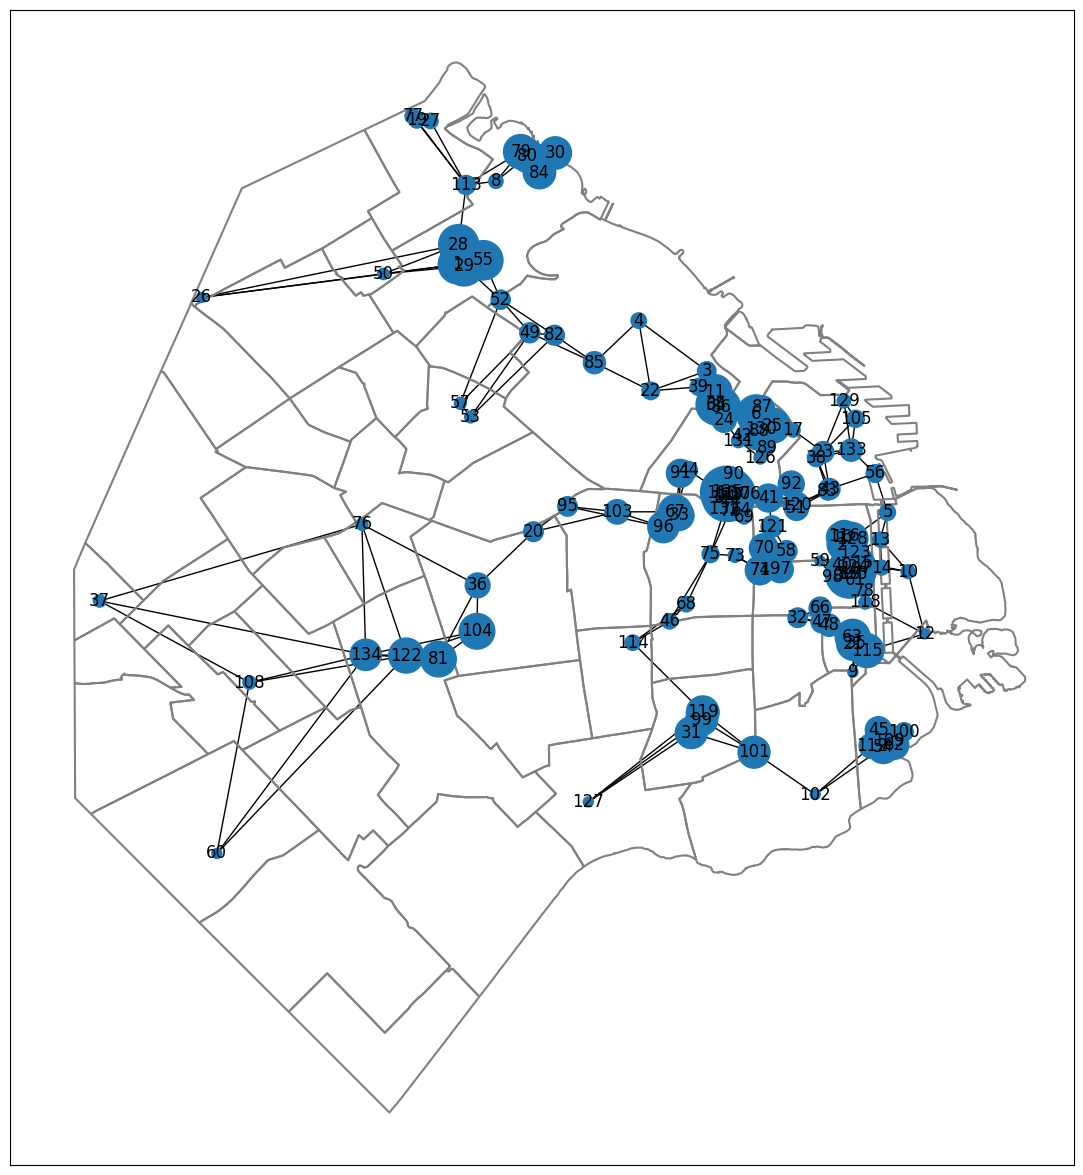

In [157]:
m = 3
alpha = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
for a in alpha:
  A = func.construye_adyacencia(D, m)
  p = func.calcula_pagerank(A,a)
  print(f"alpha = {a}")
  df = create_df(G.nodes, p.T[0], a, m)
  print(df.head(3))
  summary_df = pd.concat([summary_df, df.head(3)], ignore_index=True)
  graficar_bar_plot(df, a, m)
  graficar(p)

Par una cantidad de conexiones fija, a medida que el factor de amortiguamiento disminuye, el ranking favorece a los museos ubicados en la zonas donde hay una mayor concentración de museos pertenecientes a la red. Por el contrario, a medida que el factor de amortiguación aumenta, el ranking deja de estar tan acentuado para pasar a ser más equitativo.

Esto es consecuente con la ecuación utilizada para calcular el ranking, ya que a medida que el factor de amortiguamiento tiende a 1, la matriz de transiciones que refleja la distribución de los museos y la cantidad de conexiones pasa a tener menos peso en el ranking, y cuando tiende a 0, el ranking está cada vez marcado por la disposición de los museos en el mapa

## Punto 4:

## Punto 5:

## Punto 6:

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

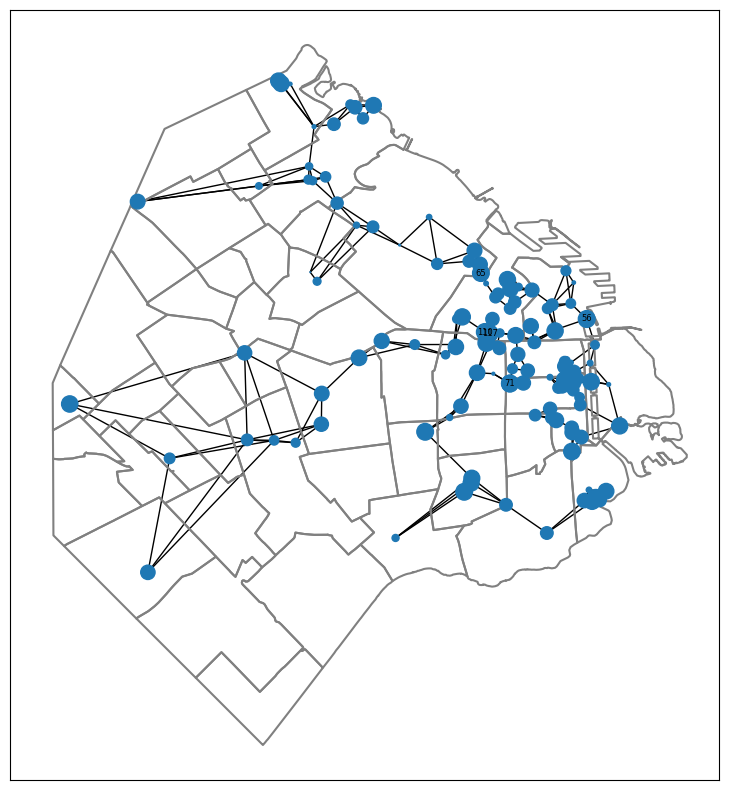

In [139]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres